![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Land Surface Temperature Product Testing

 - Sign up to the VA Datacube (INSERT LINK) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with both the NCI and DEA Sandbox environments    

 - <b>Products used</b>:
    
    products....
 
 - <b>Special requirements:</b> An optional description of any special requirements, e.g. If running on the NCI, ensure that
    module load otps is run prior to launching this notebook
 
 - <b>Prerequisites:</b> An <i>optional</i> list of any notebooks that should be run or content that should be understood
    prior to launching this notebook
 
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube, here is how:

 


## Background


An <i>optional</i> overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. For Beginners_Guide or Frequently_Used_Code notebooks, this may include information about why the particular technique or approach is useful or required. If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. Dhu et al. 2017).

## Description

A <i>compulsory</i> description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above. It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

---------------------------------------------------------------------------------------------------------------------------

## Getting started


Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import display_map, rgb

from datacube.utils.aws import configure_s3_access
configure_s3_access(profile='default', requester_pays=True)
from odc.ui import with_ui_cbk


### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [2]:
dc = datacube.Datacube(app='LST_Derived')

### Analysis parameters
An optional section to inform the user of any parameters they'll need to configure to run the notebook:
 - param_name_1: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.
 - param_name_2: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.

 

In [3]:
param_name_1 = 'example_value'
param_name_2 = 'example_value'

## Heading 1

Use headings to break up key steps/stages of the notebook.

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

<b>Note</b>: Use this markdown format (sparingly) to draw particular attention to an important point or caveat

In [4]:
# List Landsat products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    '_st').fillna(
        False)][display_columns].set_index('name')

,description
name,
ls5_c2l2_st,USGS Landsat 5 Collection 2 Level-2 Surface Te...
ls7_c2l2_st,USGS Landsat 7 Collection 2 Level-2 Surface Te...
ls8_c2l2_st,USGS Landsat 8 Collection 2 Level-2 Surface Te...
ls9_c2l2_st,USGS Landsat 9 Collection 2 Level-2 Surface Te...


In [5]:
#List measurements
dc_measurements = dc.list_measurements()
dc_measurements.loc['ls8_c2l2_st']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
lwir11,lwir11,uint16,Kelvin,0.0,"[lwir, band_6, st, surface_temperature]",NaN
TRAD,TRAD,int16,W/(m2.sr.μm),-9999.0,"[trad, ST_TRAD, thermal_radiance]",NaN
URAD,URAD,int16,W/(m2.sr.μm),-9999.0,"[urad, ST_URAD, upwell_radiance]",NaN
DRAD,DRAD,int16,W/(m2.sr.μm),-9999.0,"[drad, ST_DRAD, downwell_radiance]",NaN
ATRAN,ATRAN,int16,1,-9999.0,"[atran, ST_ATRAN, atmospheric_transmittance]",NaN
EMIS,EMIS,int16,1,-9999.0,"[emis, ST_EMIS, emissivity]",NaN
EMSD,EMSD,int16,1,-9999.0,"[emsd, ST_EMSD, emissivity_stddev]",NaN
CDIST,CDIST,int16,Kilometers,-9999.0,"[cdist, ST_CDIST, cloud_distance]",NaN
qa,qa,int16,Kelvin,-9999.0,"[st_qa, surface_temperature_quality]",NaN


In [6]:
# Define the analysis region (Lat-Lon box)
lat = 36.7401 
lon = -76.2891 

#This is going to control how large the study area is. 
lon_buffer = 0.3
lat_buffer = 0.3

# Define the time window
time_range = ('2021-05', '2022-10')

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Load land surface temperature and quality assessment
# We can use the alias names to call the bands
measurements = ['lwir11', 'qa_pixel']


In [7]:
display_map(x=lon_range, y=lat_range)

/opt/tljh/user/lib/python3.9/site-packages/deafrica_tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


In [8]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': measurements,
    'resolution': (-30, 30),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = dc.load(
    product=['ls8_c2l2_st'],
    progress_cbk=with_ui_cbk(),
    **query
)

print(ds)


<xarray.Dataset>
Dimensions:      (time: 68, y: 2055, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-06T15:40:08.945143 ... 2022-10...
  * y            (y) float64 4.41e+06 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x            (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06 -7.332e+06
    spatial_ref  int32 6933
Data variables:
    lwir11       (time, y, x) uint16 42069 42067 42069 42074 42081 ... 0 0 0 0 0
    qa_pixel     (time, y, x) uint16 21952 21952 21952 21952 21952 ... 1 1 1 1 1
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Subheading 1

Use subheadings to break up steps within a single section.

In [18]:
# Assuming your dataset is named 'ds'
ds_filtered = ds.where(ds['qa_pixel'] >= 50, drop=True)

# Check the filtered dataset
print(ds_filtered)

<xarray.Dataset>
Dimensions:      (time: 68, y: 2055, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-06T15:40:08.945143 ... 2022-10...
  * y            (y) float64 4.41e+06 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x            (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06 -7.332e+06
    spatial_ref  int32 6933
Data variables:
    lwir11       (time, y, x) float64 4.207e+04 4.207e+04 4.207e+04 ... nan nan
    qa_pixel     (time, y, x) float64 2.195e+04 2.195e+04 2.195e+04 ... nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [19]:
# Convert from digital number (DN) to Kelvin to Celsius: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products
ds_filtered = ds_filtered.dropna(dim='time', how='all')
ds_filtered['lwir11'] = ((ds_filtered.lwir11 * 0.00341802) + 149) - 273.15

print(ds_filtered)

<xarray.Dataset>
Dimensions:      (time: 68, y: 2055, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-06T15:40:08.945143 ... 2022-10...
  * y            (y) float64 4.41e+06 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x            (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06 -7.332e+06
    spatial_ref  int32 6933
Data variables:
    lwir11       (time, y, x) float64 19.64 19.64 19.64 19.66 ... nan nan nan
    qa_pixel     (time, y, x) float64 2.195e+04 2.195e+04 2.195e+04 ... nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


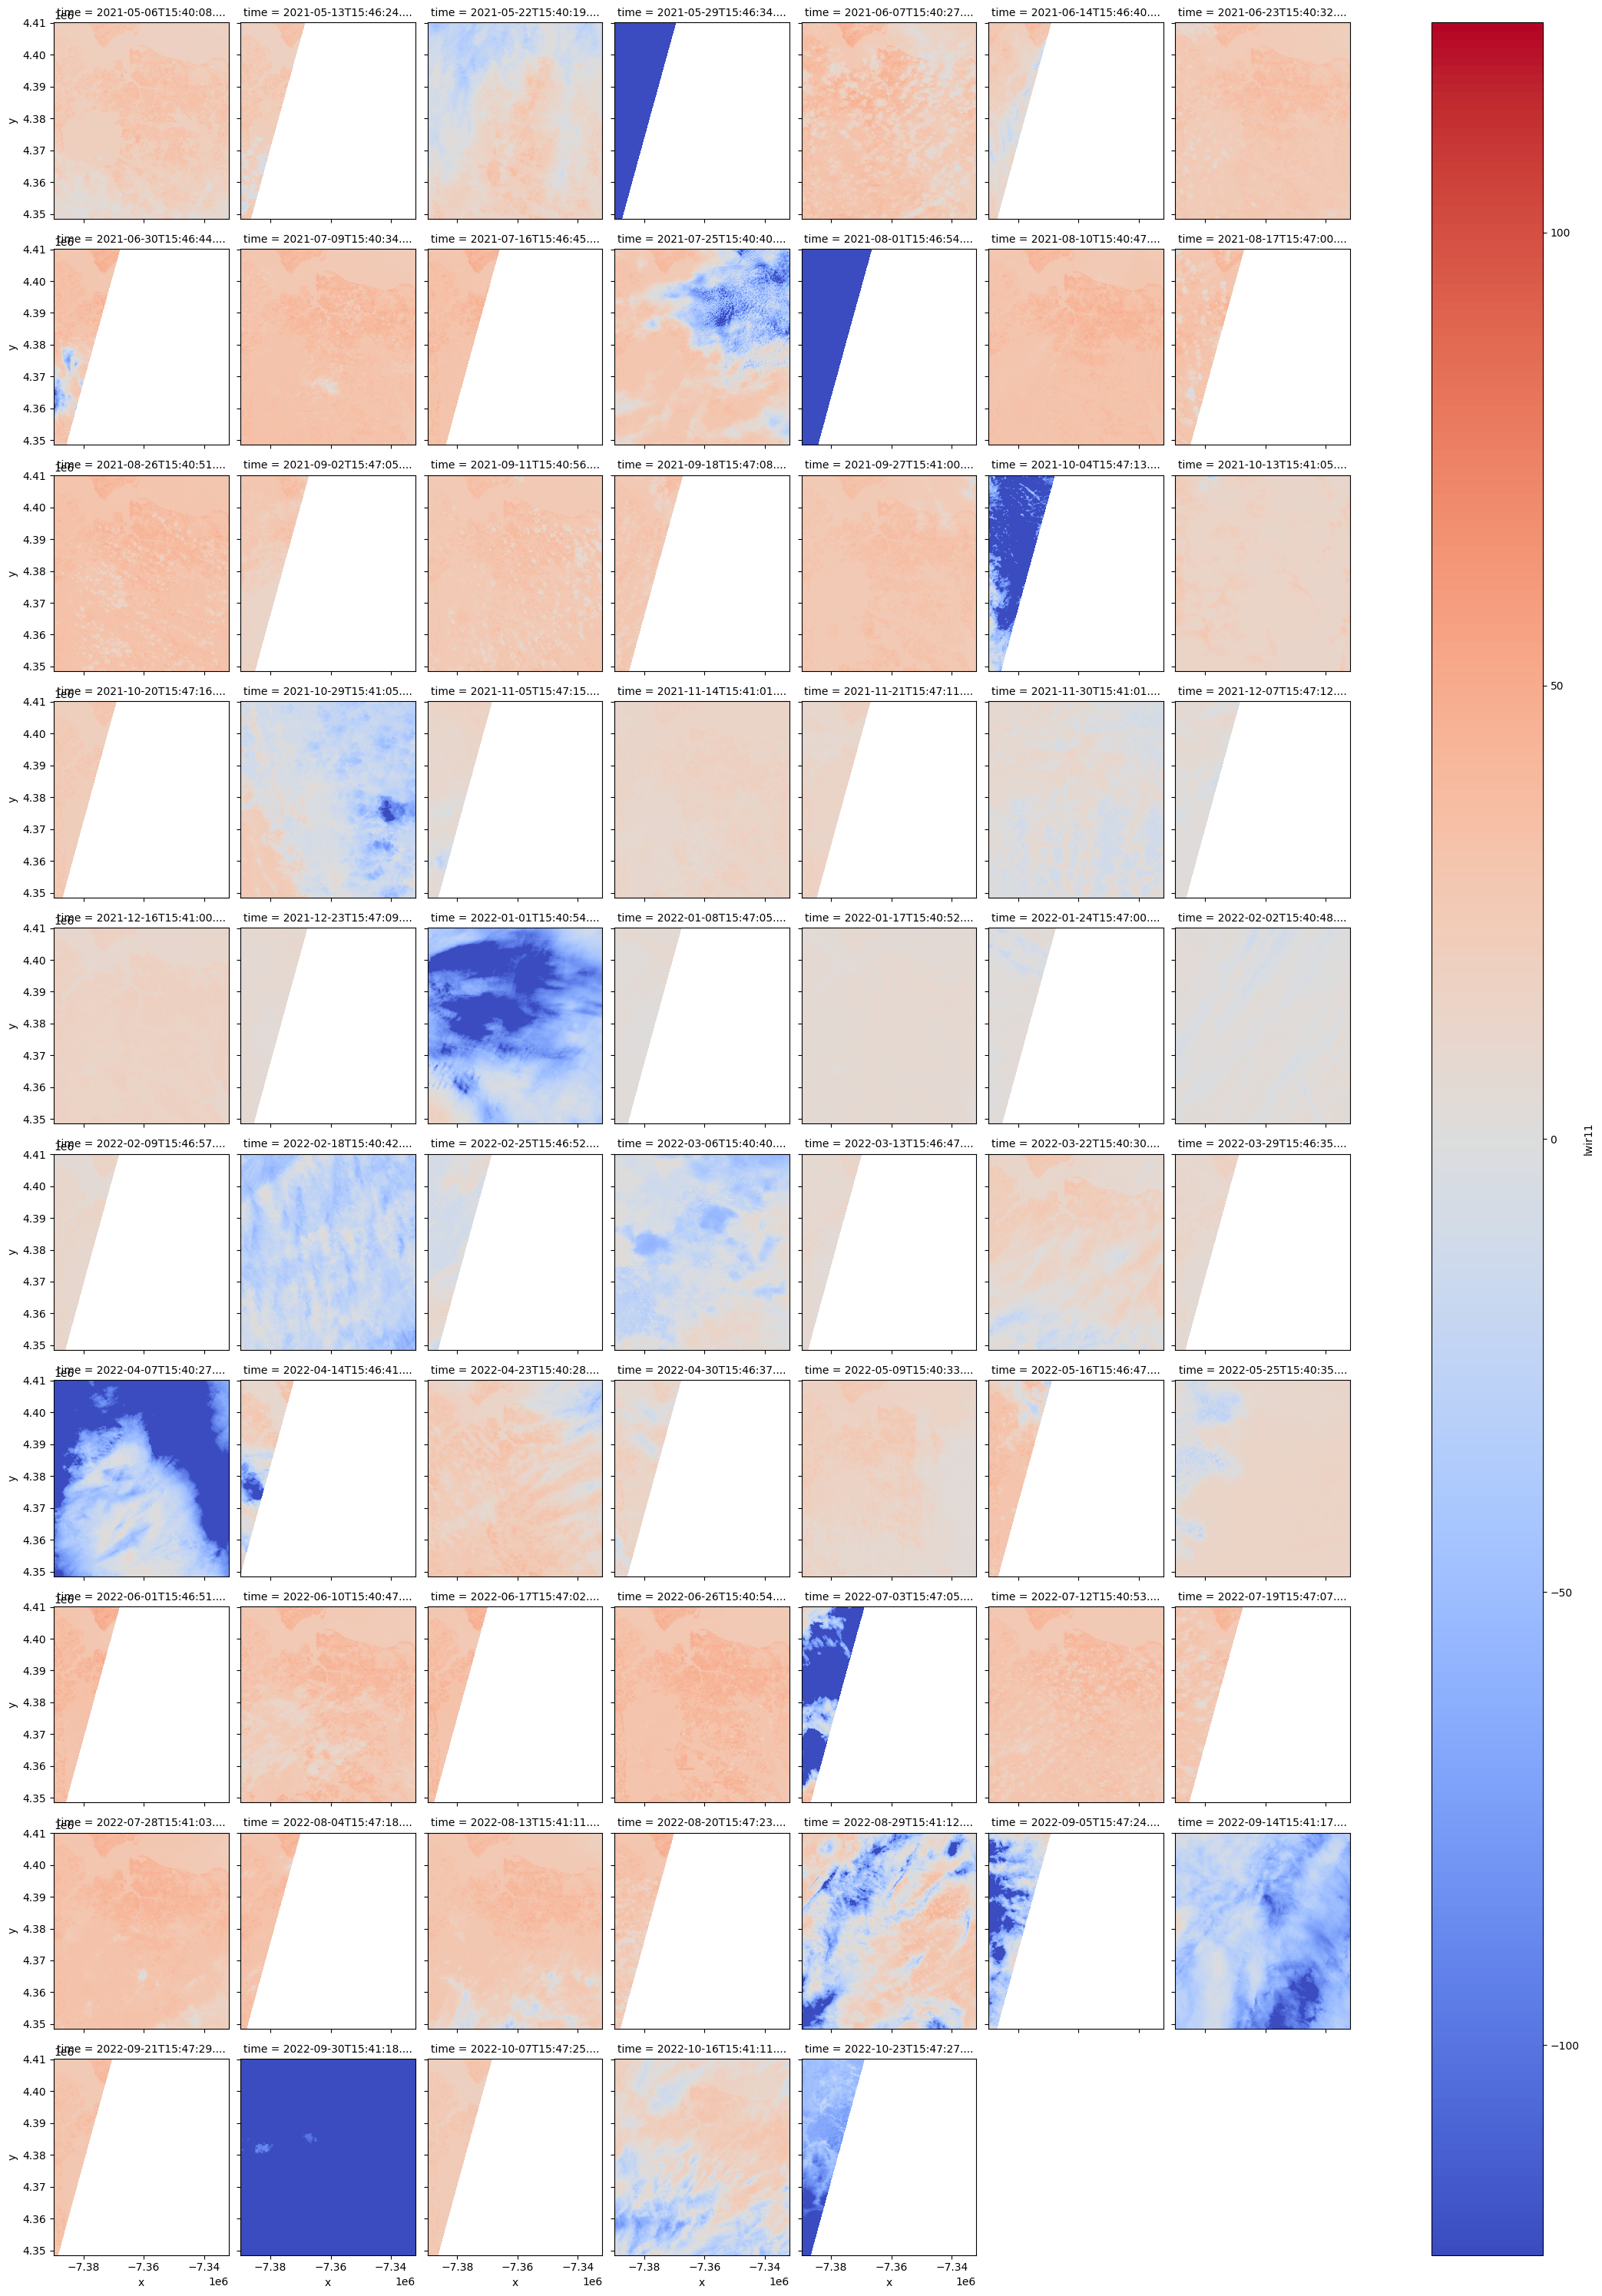

In [20]:
ds_filtered.lwir11.plot.imshow(col='time', col_wrap=7, cmap='coolwarm');

## Heading 2

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.


In [33]:
# Calculate mean
ds_mean = ds.groupby('time').mean(dim=xr.ALL_DIMS)

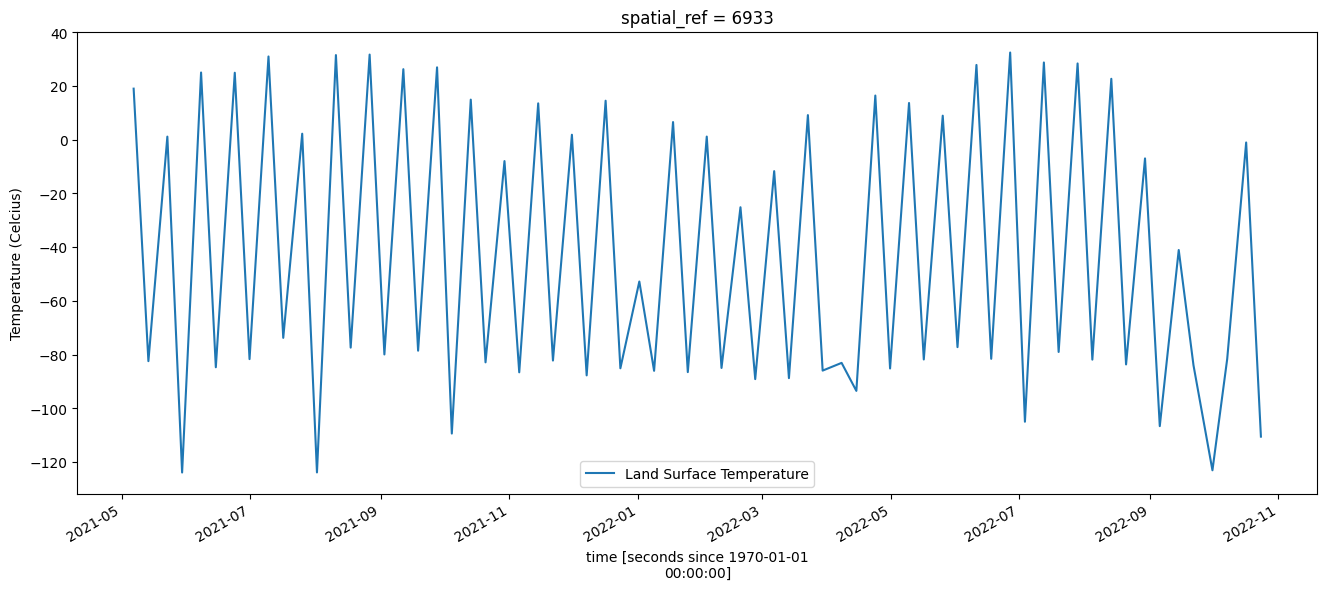

In [34]:
# Plot
ds_mean.lwir11.plot(figsize = (16, 6),label='Land Surface Temperature');
plt.ylabel('Temperature (Celcius)')
plt.legend()

## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Digital Earth Australia data is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions here). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2020

<b>Compatible datacube version:</b>

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 